# Proyecto Individual N° 2 - Data Analytics - Accidentes aereos

## 1. Librerias

In [1]:
!pip install pyspark
#pip install PIL
#pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, lower

import matplotlib.pyplot as plt
from wordcloud import WordCloud , STOPWORDS
from PIL import Image

import csv

## 2. Archivo Original

In [3]:
flight_df = pd.read_csv('AC_accidents_INPUTS.csv')

In [4]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5008 non-null   int64 
 1   fecha                   5008 non-null   object
 2   HORA declarada          5008 non-null   object
 3   Ruta                    5008 non-null   object
 4   OperadOR                5008 non-null   object
 5   flight_no               5008 non-null   object
 6   route                   5008 non-null   object
 7   ac_type                 5008 non-null   object
 8   registration            5008 non-null   object
 9   cn_ln                   5008 non-null   object
 10  all_aboard              5008 non-null   object
 11  PASAJEROS A BORDO       5008 non-null   object
 12  crew_aboard             5008 non-null   object
 13  cantidad de fallecidos  5008 non-null   object
 14  passenger_fatalities    5008 non-null   object
 15  crew

### 2.1 columna 'ground'

In [5]:
ground = flight_df[flight_df['ground'] != '0']
ground = ground[['ground', 'summary']]
# Para ver el contenido de la columna 'summary' enteramente.
pd.set_option('display.max_colwidth', None)
ground

,ground,summary
26,10,"The dirigible, cruising at 1,200 ft. caught fire and crashed into the Illinois Trust and Savings Building in Chicago. The was transporting people from Grant Park to the White City amusement park.[1] One crew member, two passengers, and ten bank employees were killed"
60,1,"Crashed due to structural failure followed by two explosions and a fire. Attributed to faulty design. This was a test flight before being handed over to the navy. Thirty-two British and 17 Americans were on board, and the survivors were 5 British and 1 American. The fatalities included the designer, Charles Campbell, who had copied a captured German design intended for high-altitude flight, therefore the skeleton was a bit weaker than some. The pilot overstressed it by attempting a turn at 62 mph at low altitude."
63,5,Crashed at Le Bourget field.
103,?,?
234,?,"Fflying over the Darling Range, aircraft went out of control and dove into a hilly terrain,"
...,...,...
4988,14,"The Pakistani military plane, on a training flight, crashed into residential structures in Mora Kalu Village on the outskirts of Rawalpindi. The aircraft was destroyed killing 18 people, including the 2 pilots, 3 crew members and 14 civilians on the ground."
4991,7,"The passenger plane crashed about a minute after taking off from Goma Airport into the Mapendo neighborhood,"
4993,?,"The aircraft crashed shortly after taking off from the airport, killing alll 18 occupants, including three children. The aircraft was returning to Khartoum after delivering medical aid."
4997,1,"While landing, the aircraft scraped the runway three times. After the third impact, the pilot took the plane into the air. During his attempt to land, the engines oil tanks and fuel pumps were damaged. The plane managed to climb to 1,800 feet. The damage led to the loss of both engines. The crew declared a Mayday. The aircraft then descended fast, almost plunging. The plane impacted a residential area called Model Colony, featuring concrete multstory buildings, 0.74 miles short of runway 25L."


Según lo referido a la columna 'summary' , la columna 'ground' hace referencia a la cantidad de victimas terrestres producto de la colisión de las aeronaves, o partes de ellas, en Tierra.

## 3. Procesamiento de datos

In [6]:
# Para volver a reducir el contenido de la columna 'summary'
pd.reset_option('display.max_colwidth')

  *Nombre de las columnas:*<br>
    "Unnamed" , "fecha" , "HORA declarada" , "Ruta" , "OperadOR" , "flight_no" , "route" , "ac_type" ,
    "registration" , "cn_ln" , "all_aboard" , "PASAJEROS A BORDO" , "crew_aboard" ,
    "cantidad de fallecidos" , "passenger_fatalities" , "crew_fatalities" , "ground" , "summary")
    "Unnamed" , "fecha" , "HORA declarada" , "Ruta" , "OperadOR" , "flight_no" , "route" , "ac_type" ,
    "registration" , "cn_ln" , "all_aboard" , "PASAJEROS A BORDO" , "crew_aboard" ,
    "cantidad de fallecidos" , "passenger_fatalities" , "crew_fatalities" , "ground" , "summary"

In [7]:
# Cambio de nombres de las columnas
names_news= [
    "Flight_id" , "Date" , "Time" , "Loc Acc" , "Operator" , "Flight Num" , "Route" , "AC Model" ,
    "Registration" , "Serie" , "Total Aboard" , "Passengers" , "Crew" ,
    "Total Fatalities" , "Passengers Fatalities" , "Crew Fatalities" , "Ground Fatalities" , "Summary"
    ]

**Date** - *Día del accidente* <br>
**Time** - *Hora del accidente* <br>
**Loc Acc** - *Lugar del accidente* <br>
**Operator** - *Aerolinea u operador* <br>
**Flight Num** - *Número de vuelo* <br>
**Route** - *Ruta completa o parcial volada antes del accidente* <br>
**AC Model** - *Modelo de Aeronave* <br>
**Registration** - *Registro de la aeronave* <br>
**Serie** - *Número de serie constituido por el número de construcción y el número de línea (Cn/Ln)* <br>
**Total aboard** - *Total de personas a bordo* <br>
**Passengers** - *Pasajeros a bordo* <br>
**Crew** - *Tripulación* <br>
**Total Fatalities** - *Victimas a bordo* <br>
**Passengers Fatalities** - *Decesos de pasajeros* <br>
**Crew Fatalities** - *Decesos de tripulantes* <br>
**Ground Fatalities** - *Decesos personas en tierra* <br>
**Summary** - *Resumen del accidente* <br>

In [8]:
flight_df.columns = names_news

In [9]:
flight_df.isna().sum()

Flight_id                0
Date                     0
Time                     0
Loc Acc                  0
Operator                 0
Flight Num               0
Route                    0
AC Model                 0
Registration             0
Serie                    0
Total Aboard             0
Passengers               0
Crew                     0
Total Fatalities         0
Passengers Fatalities    0
Crew Fatalities          0
Ground Fatalities        0
Summary                  0
dtype: int64

In [10]:
# Encuentra las filas duplicadas
def duplicates (df):
  d = flight_df.duplicated().any()
  if d:
    return 'Hay registros duplicados'
  return 'No hay duplicados'

# Llamar a la función
duplicates(flight_df)

'No hay duplicados'

In [11]:
# Elimina las columnas innecesarias
flight_df.drop(columns = ['Flight_id' ,'Flight Num' , 'Registration' , 'Serie' ,'Ground Fatalities'] , axis = 1 , inplace = True)

In [12]:
# Reemplaza todos los '?' por NaN en todo el DataFrame
flight_df.replace('?', np.nan, inplace=True)

In [13]:
# Cuenta los registros con al menos un NaN
rows_nan = flight_df.isna().any(axis=1).sum()
rows_nan

1787

In [14]:
# Cantidad de Nan por columna
flight_df.isna().sum()

Date                        0
Time                     1504
Loc Acc                     5
Operator                   10
Route                     762
AC Model                   13
Total Aboard               17
Passengers                221
Crew                      219
Total Fatalities            8
Passengers Fatalities     235
Crew Fatalities           235
Summary                    59
dtype: int64

In [15]:
# Elimina los registros sin valores en las columnas 'Total Fatalities' , 'Summary' y 'Total Aboard'
no_fatalities = flight_df['Total Fatalities'].isna()
no_summary = flight_df['Summary'].isna()
no_passengers = flight_df['Total Aboard'].isna()

flight_df.drop(flight_df[no_fatalities & no_summary & no_passengers].index, inplace = True )

In [16]:
flight_df.reset_index(drop=True, inplace=True)

### 3.1 Columna 'Date'

In [17]:
# Convierte la columna 'Date' al formato deseado yyyy-mm-dd
flight_df['Date'] = pd.to_datetime(flight_df['Date'], format='%B %d, %Y')

In [18]:
# Deteccón de años fuera de rango
def year_outlier(Date):
    years = Date.dt.year.tolist()
    outliers = []

    for year in years:
        if year not in range(1900, 2023):
            outliers.append(flight_df[flight_df['Date'].dt.day == year])

    if outliers:
        return outliers
    else:
        return print("No se encontraron años fuera del rango esperado.")

# Llamar a la función pasando la columna 'Date'
outliers = year_outlier(flight_df['Date'])

No se encontraron años fuera del rango esperado.


In [19]:
# Deteccón de meses fuera de rango
def mounth_outlier(Date):
    months = Date.dt.month.tolist()
    outliers = []

    for month in months:
        if month not in range(1, 13):
            outliers.append(flight_df[flight_df['Date'].dt.day == month])

    if outliers:
        return print(outliers)
    else:
        return print("No se encontraron meses fuera del rango esperado.")

# Llamar a la función pasando la columna 'Date'
outliers = mounth_outlier(flight_df['Date'])

No se encontraron meses fuera del rango esperado.


In [20]:
# Detección de dias fuera de rango
def day_outlier(Date):
    days = Date.dt.day.tolist()
    outliers = []

    for day in days:
        if day not in range(1, 32):
            outliers.append(flight_df[flight_df['Date'].dt.day == day])

    if outliers:
        return print(outliers)
    else:
        return print("No se encontraron dias fuera del rango esperado.")

# Llamar a la función pasando la columna 'Date'
outliers = day_outlier(flight_df['Date'])

No se encontraron dias fuera del rango esperado.


### 3.2 Columna 'Time'

In [21]:
# Cambia el formato fecha por HH:MM en la columna 'Time'
flight_df['Time'] = flight_df['Time'].str[:2] + ':' + flight_df['Time'].str[2:]

In [22]:
# Se obtiene los valores únicos de la columna 'time'
values = flight_df['Time'].astype(str).unique()

# Recorre los valores ordenados del 20 al 45 para visualizar algunos errores
for v in range (20,46):
    print(values[v])

13:42
17:30
c :18:00
c :02:30
c :12:00
05:30
09:30
15:27
c :13:15
08:00
08:30
04:05
10::00
14::48
c :11:00
c :9:15
11::30
c :10:00
08::00
10::45
17:00
09::18
11:45
11:30
21:00
11:01


In [23]:
# Normalización para obtener solamente la hora (HH)
def extract_digits(value):
    if pd.isnull(value):  # Comprueba si el valor es nulo
        return value
    digits = ''.join(filter(str.isdigit, value))  # Filtra solo los dígitos del valor
    return digits[:2] if len(digits) >= 2 else digits

# Aplica la función en la columna 'Time'
flight_df['Time'] = flight_df['Time'].apply(extract_digits)

In [24]:
# Control de valores únicos
values = flight_df['Time'].astype(str).unique()

# Se Ordenan los valores
values.sort()

# Recorre los valores ordenados
for v in values:
    print(v)

00
01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
90
91
nan


In [25]:
# Corrección de las horas fuera del rango 00 a 23
def replace_values(value):
    if pd.isnull(value):  # Comprueba si el valor es nulo
        return value
    value = value.replace('91', '19').replace('90', '09').replace('24', '00')
    return value

# Aplica la función
flight_df['Time'] = flight_df['Time'].apply(replace_values)

In [26]:
# Control de valores únicos
values = flight_df['Time'].astype(str).unique()

# Se ordenan los valores
values.sort()

# Recorre los valores ordenados
for v in values:
    print(v)


00
01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23
nan


### 3.3 Columnas a flotantes

In [27]:
# Se Cambia a tipo flotantes las columnas correspondientes
col_to_int = [
    'Total Aboard' , 'Passengers' , 'Crew' ,
    'Total Fatalities' , 'Passengers Fatalities' , 'Crew Fatalities'
    ]

flight_df[col_to_int] = flight_df[col_to_int].astype(float)


In [28]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5004 entries, 0 to 5003
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   5004 non-null   datetime64[ns]
 1   Time                   3504 non-null   object        
 2   Loc Acc                4999 non-null   object        
 3   Operator               4994 non-null   object        
 4   Route                  4246 non-null   object        
 5   AC Model               4992 non-null   object        
 6   Total Aboard           4991 non-null   float64       
 7   Passengers             4787 non-null   float64       
 8   Crew                   4789 non-null   float64       
 9   Total Fatalities       5000 non-null   float64       
 10  Passengers Fatalities  4773 non-null   float64       
 11  Crew Fatalities        4773 non-null   float64       
 12  Summary                4949 non-null   object        
dtypes: 

### 3.4 Columna 'Loc Acc'  y creación de la columna 'Location'

In [29]:
# Obtención del País/locación del accidente
Loc_acc = flight_df['Loc Acc'].fillna('')
Location = []

for i in Loc_acc:
    x1 = i.split(',') # Utiliza la coma para dividir la cadena ej. 'Lima, Peru' -------> ['Lima', 'Peru']
    x2 = x1[-1].strip() # Almacena la última palabra ej. 'Peru'
                        # Se usa strip() para eliminar espacios en blanco adicionales
    Location.append(x2)

Se crea la nueva columna 'Location', la cual contiene los paises o locaciones de los accidentes.

In [30]:
flight_df['Location'] = Location

In [31]:
flight_df[['Loc Acc' , 'Location']].head()

,Loc Acc,Location
0,"Fort Myer, Virginia",Virginia
1,"Juvisy-sur-Orge, France",France
2,"Atlantic City, New Jersey",New Jersey
3,"Victoria, British Columbia, Canada",Canada
4,Over the North Sea,Over the North Sea


In [32]:
# En el caso de accidentes ocurridos en EE.UU, se cambian los estados por el país (USA) en la columna 'Location'
states_usa = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado",
    "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois",
    "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
    "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana",
    "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York",
    "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
    "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
    "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
]

# Recorre el DataFrame y reemplazamos los estados de Estados Unidos por 'USA'
for i in range(len(flight_df)):
    if flight_df.loc[i, 'Location'] in states_usa:
        flight_df.loc[i, 'Location'] = 'USA'

In [33]:
flight_df[ 'Location'].nunique()

471

Como existen Paises con nombres alternativos se utiliza PySpark para realizar consultas SQL y evidenciar estos casos de mejor manera.

In [34]:
# Crear una sesión Spark
spark = SparkSession.builder.appName("AC_Accidents_SQL") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.driver.extraJavaOptions", "-Dderby.system.home=/tmp/derby") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "2") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.network.timeout", "600s") \
    .getOrCreate()

# Ajustar la configuración para mostrar los registros completos
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 20)

# Convertir el DataFrame de Pandas a un DataFrame de PySpark
flight_df_spark = spark.createDataFrame(flight_df)

# Registrar el DataFrame de PySpark como una vista temporal para ejecutar consultas SQL
flight_df_spark.createOrReplaceTempView("flight_table")


In [35]:
# Consulta SQL, paises con el nombre 'united'
resultado = spark.sql("SELECT `Loc Acc`,Location FROM flight_table WHERE lower(location) LIKE '%united%' ")

# Mostrar los resultados
resultado.show(truncate=False)

+--------------------------------------+----------------------------------+
|Loc Acc                               |Location                          |
+--------------------------------------+----------------------------------+
|East Mallling, United Kingdom         |United Kingdom                    |
|United States                         |United States                     |
|Cardiff, United Kingdom               |United Kingdom                    |
|Selby, North Yorkshire, United Kingdom|United Kingdom                    |
|Croydon, United Kingdom               |United Kingdom                    |
|Forest-in-Teesdale. United Kingdom    |Forest-in-Teesdale. United Kingdom|
|Sharjah, United Arab Emirates         |United Arab Emirates              |
|Near Al Fujayrah, United Arab Emirates|United Arab Emirates              |
|Griesta, United Kingdom               |United Kingdom                    |
|Sharjah, United Arab Emirates         |United Arab Emirates              |
|Off Rasal, 

In [36]:
# Consulta SQL, paises con el nombre 'congo'
resultado = spark.sql("SELECT `Loc Acc`,  Location FROM flight_table WHERE lower(Location) LIKE '%congo%' ")

# Mostrar los resultados
resultado.show(truncate=False)

+----------------------------------------------+--------------------------------+
|Loc Acc                                       |Location                        |
+----------------------------------------------+--------------------------------+
|Near Magazini, Belgian Congo (Zaire)          |Belgian Congo (Zaire)           |
|Near Elizabethville, Belgium Congo            |Belgium Congo                   |
|Kikwit, Belgian Congo                         |Belgian Congo                   |
|Bunia, Belgian Congo                          |Belgian Congo                   |
|Leopoldville, Democratic Republic of the Congo|Democratic Republic of the Congo|
|Congo                                         |Congo                           |
|Near Kinkala, Congo                           |Congo                           |
|Etsouali, Congo                               |Congo                           |
|Goma, Congo                                   |Congo                           |
|Kinshasa, Democ

Como se puede apreciar en las 2 consultas anteriores, existen alternativas para referirse a un País en particular, ej.

   1. USA, United States.
   2. Congo, Belgian Congo, Democratic Republic Congo, etc.<br>

Además se tiene el caso de United Kingdom, una región integrada por paises entre los cuales se encuentra:
   1. England.
   2. Wales
   3. Scotland

A continuación se **Normalizaran** los casos, tantos los expuestos como el resto.  

In [37]:
# Lista de Paises
list_countries = [
    "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia",
    "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium",
    "Belize", "Benin", "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria",
    "Burkina Faso", "Burundi", "Côte d'Ivoire", "Cabo Verde", "Cambodia", "Cameroon", "Canada",
    "Central African Republic", "Chad", "Chile", "China", "Colombia", "Comoros", "Congo", "Costa Rica", "Croatia",
    "Cuba", "Cyprus", "Czech Republic", "Democratic Republic of the Congo", "Denmark", "Djibouti", "Dominica",
    "Dominican Republic", "Ecuador", "England", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia",
    "Eswatini", "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece",
    "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Holy See", "Honduras", "Hungary",
    "Iceland", "India", "Indonesia", "Iran", "Iraq", "Ireland", "Israel", "Italy","Ivory Coast", "Jamaica", "Japan", "Jordan",
    "Kazakhstan", "Kenya", "Kiribati", "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia",
    "Libya", "Liechtenstein", "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali",
    "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia",
    "Montenegro", "Morocco", "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal", "Netherlands", "New Zealand",
    "Nicaragua", "Nigeria", "Niger", "North Korea", "Macedonia", "Northern Ireland", "Norway", "Oman", "Pakistan", "Palau",
    "Palestine State", "Panama", "Papua", "New Guinea", "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Puerto Rico",
    "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts and Nevis", "Saint Lucia",
    "Saint Vincent and the Grenadines", "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Scotland",
    "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia",
    "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka", "Sudan", "Suriname", "Sweden", "Switzerland",
    "Syria", "Tajikistan", "Taiwan", "Tanzania", "Thailand", "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago",
    "Tunisia", "Turkey", "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates",
    "Uruguay", "USA", "Uzbekistan", "Vanuatu", "Venezuela", "Vietnam", "Wales", "Yemen", "Zambia", "Zimbabwe",
    "Pacific Ocean", "Atlantic Ocean", "Indian Ocean", "North Sea", "Mediterranean Sea", "Black Sea"
]

In [38]:
# Actualizar la columna 'Location' con la lista de Paises
for c in list_countries:
  flight_df_spark = flight_df_spark.withColumn(
      'Location',
       when(col('Location').like(f'% {c}') |
            col('Loc Acc').like(f'%{c}%') & col('Loc Acc').like('%USSR%')
            , c)
      .otherwise(col('Location'))
  )

In [39]:
# Actualización de la tabla "flight_table" con los cambios anteriores
flight_df_spark.createOrReplaceTempView("flight_table")

In [40]:
# Verificación mediante consulta SQL, ej. 'gulf of finland'
resultado = spark.sql("SELECT `Loc Acc`,  Location FROM flight_table WHERE lower(`Loc Acc`) LIKE '%gulf of finland%' ")

# Mostrar los resultados
resultado.show(truncate=False)

+--------------------------------------------+--------+
|Loc Acc                                     |Location|
+--------------------------------------------+--------+
|Over the Gulf of Finland                    |Finland |
|Over the Gulf of Finland                    |Finland |
|Gulf of Finland                             |Finland |
|Off Prangli Island, Gulf of Finland, Estonia|Estonia |
|Gulf of Finland, Russia                     |Russia  |
+--------------------------------------------+--------+



In [41]:
# Normalización de otras locaciones no contempladas en las transformaciones anteriores
flight_df_spark = flight_df_spark.withColumn(
    'Location',
    # Paises varios
     when(lower(col('Location')).like('%uae%'), 'United Arab Emirates')
    .when(lower(col('Location')).like('%congo%'), 'Congo')
    .when(lower(col('Location')).like('%soviet%'), 'Russia')
    .when(lower(col('Location')).like('%ussr%') , 'Russia')
    .when(lower(col('Location')).like('%russia%'), 'Russia')
    .when(lower(col('Location')).like('%vietnam%'), 'Vietnam')
    .when(lower(col('Location')).like('%reunion%'), 'France')
    .when(lower(col('Location')).like('%domin%'), 'Dominican Republic')
    .when(lower(col('Location')).like('%mozamb%'), 'Mozambique')
    .when(lower(col('Location')).like('%myanmar%'), 'Myanmar')
    .when(lower(col('Location')).like('%zimbabwe)%'), 'Zimbabwe')
    .when(lower(col('Location')).like('%portugal%'), 'Portugal')
    .when(lower(col('Location')).like('%taiwan%'), 'Taiwan')
    .when(lower(col('Location')).like('%newfoundland%'), 'Canada')
    .when(lower(col('Location')).like('%argentina%'), 'Argentina')
    .when(lower(col('Loc Acc')).like('%new guinea%'), 'New Guinea')
    .when(lower(col('Loc Acc')).like('%mumbai%'), 'India')
    .when(lower(col('Loc Acc')).like('%estonia%'), 'Estonia')
    .when(lower(col('Loc Acc')).like('%oman%'), 'Oman')
    .when(lower(col('Loc Acc')).like('%surinam%'), 'Suriname')
    .when(lower(col('Loc Acc')).like('%barquisimeto%'), 'Venezuela')
    .when(col('Loc Acc').like('%Fox Glacier Airstrip%'), 'New Zealand')
    .when(col('Loc Acc').like('%netherlands%'), 'Netherlands')

    # Océanos y mares
    .when(lower(col('Loc Acc')).like('%pacific ocean%'), 'Pacific Ocean')
    .when(lower(col('Loc Acc')).like('%atlantic ocean%'), 'Atlantic Ocean')
    .when(lower(col('Loc Acc')).like('%indian ocean%'), 'Indian Ocean')
    .when(lower(col('Loc Acc')).like('%north sea%'), 'North Sea')
    .when(lower(col('Loc Acc')).like('%mediterranean sea%'), 'Mediterranean Sea')
    .when(lower(col('Loc Acc')).like('%black sea%'), 'Black Sea')

    # Estados Unidos, 'USA'
    .when(lower(col('Location')).like('%united states%'), 'USA')
    .when(lower(col('Location')).like('%new york%'), 'USA')
    .when(lower(col('Location')).like('%californiia%'), 'USA')
    .when(lower(col('Location')).like('%alaska%'), 'USA')
    .when(lower(col('Location')).like('%alak%'), 'USA')
    .when(lower(col('Location')).like('%massach%'), 'USA')
    .when(lower(col('Location')).like('%missis%'), 'USA')
    .when(lower(col('Location')).like('%airzona%'), 'USA')

    # Reino Unido, 'United Kingdoms'
    .when(col('Loc Acc').like('%East Mallling%'), 'England')
    .when(col('Loc Acc').like('%Cardiff,%'), 'Wales')
    .when(col('Loc Acc').like('%Selby,%'), 'England')
    .when(col('Loc Acc').like('%Croydon,%'), 'England')
    .when(col('Loc Acc').like('%Forest-in-Teesdale%'), 'England')
    .when(col('Loc Acc').like('%Griesta,%'), 'England')
    .when(col('Loc Acc').like('%Hallingbury%'), 'England')
    .when(col('Loc Acc').like('%Off Campbeltown%'), 'Scotland')

    # Colonias y territorios Franceses
    .when(col('Loc Acc').like('%Dakar%'), 'Senegal')
    .when(col('Loc Acc').like('%Bangui%'), 'Congo')
    .when(col('Loc Acc').like('%Eaeka%'), 'Cameroon')
    .when(col('Loc Acc').like('%Djiring%'), 'Vietnam')
    .when(col('Loc Acc').like('%Gao%'), 'Mali')
    .when(col('Loc Acc').like('%Phou-Lassy%'), 'Laos')
    .when(col('Loc Acc').like('%omaliland%'), 'Djibouti')
    .when(col('Loc Acc').like('%French%'), 'France')
    .when(lower(col('Loc Acc')).like('%tahiti%'), 'France')
    .when(lower(col('Location')).like('%french%'), 'France')
    .when(lower(col('Location')).like('%french%'), 'France')
    .when(lower(col('Location')).like('%new caledonia%'), 'France')

    .otherwise(col('Location'))
)

In [42]:
# Actualiza el DataFrame "flight_df" con los cambios anteriores
flight_df = pd.DataFrame(flight_df_spark.toPandas())

Aún existen algunas locaciones sin normalizar, esto se debe a varios factores como por ejemplo:

1. La simplificación del nombre del País o territorio.
2. Errores de tipeo.
3. No especificar el País del accidente.
4. Otros.
    
A todas las locaciones sin Normalizar se las denominará **'Other'**

In [43]:
# Renombramiento a 'Other'
flight_df.loc[~flight_df["Location"].isin(list_countries), 'Location'] = "Other"

# Cantidad de Locaciones = 'Other'
Other = flight_df[flight_df['Location'] == 'Other']['Location']
print(f'La cantidad de locaciones = Other es: {Other.count()}')

# Cantidad de Locaciones con Paises
Countries = flight_df[flight_df['Location'] != 'Other']['Location']
print(f'La cantidad de locaciones con paises es: {Countries.count()}')

La cantidad de locaciones = Other es: 301
La cantidad de locaciones con paises es: 4703


Las localizaciones 'Other' son una cantidad despreciable

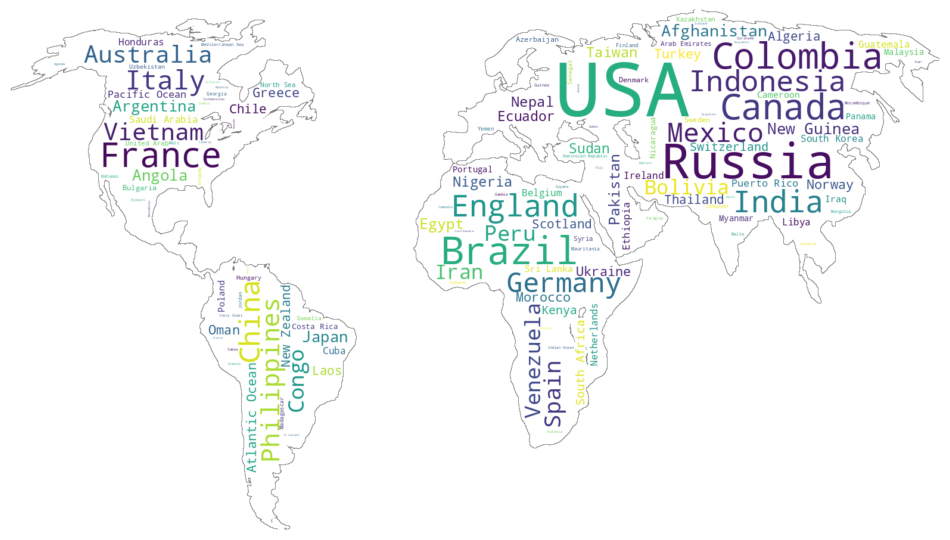

In [44]:
# Nube de Palabras

# Extrae los nombres de paises de la columna 'Location'
countries = Countries.tolist()

# Se unen los nombres de países en una cadena separada por espacios
text = ' '.join(countries)

# Imagen a utilizar
world_map_image = 'mapa2.png'

# Crea una máscara a partir de la imagen
world_mask = np.array(Image.open(world_map_image))

# Crea una instancia de WordCloud con la máscara
wc = WordCloud(background_color='white', mask=world_mask, contour_width=1, contour_color='grey' )

# Genera la nube de palabras
wc.generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(12, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [45]:
# Análisis de Pareto - 50%
# Contar la frecuencia de cada país
countries = Countries.value_counts().reset_index()
countries.columns = ['Pais', 'Frecuencia']

# Calcular la frecuencia relativa (porcentaje de frecuencia)
rows = len(flight_df)
countries['Frecuencia_Relativa'] = (countries['Frecuencia'] / rows) * 100

# Ordenar los países por frecuencia descendente
countries = countries.sort_values(by='Frecuencia', ascending=False)

# Calcular la frecuencia acumulada
countries['Frecuencia_Acumulada'] = countries['Frecuencia_Relativa'].cumsum()

In [46]:
top = countries[countries['Frecuencia_Acumulada']<50]

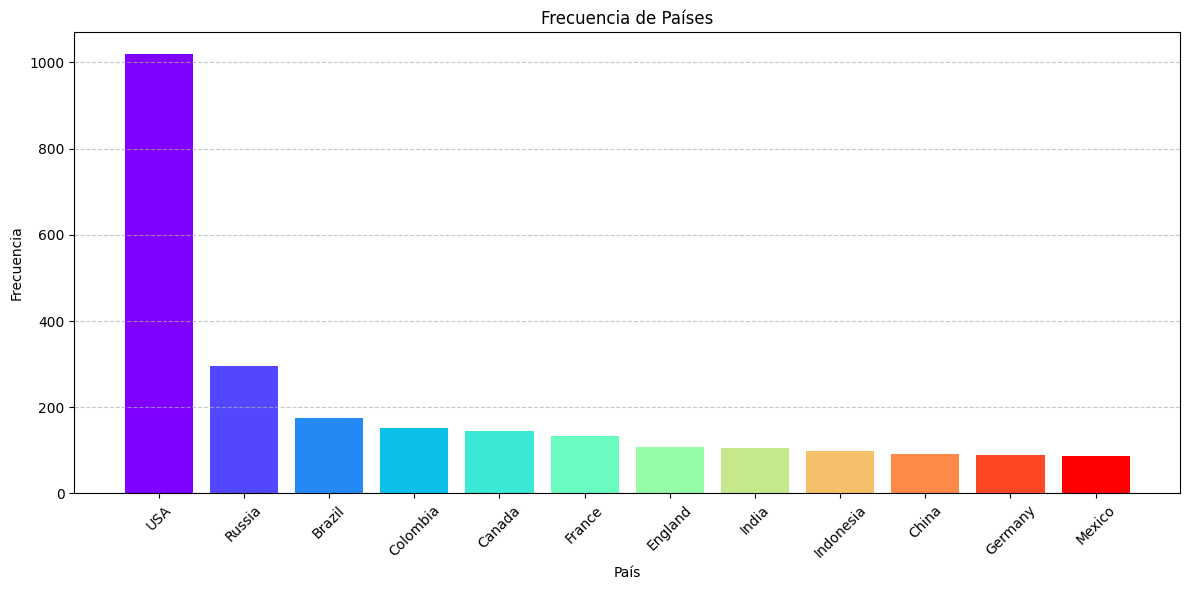

In [47]:
# Crea una secuencia de valores entre 0 y 1
colors = np.linspace(0, 1, len(top))

# Crea la paleta de colores tipo "rainbow" a partir de la secuencia
colors_rainbow = plt.cm.rainbow(colors)

# Crea el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(top['Pais'], top['Frecuencia'], color=colors_rainbow)
plt.xlabel('País')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Países')
plt.xticks(rotation=45)

# Agrega una cuadrícula al gráfico
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Se puede observar como el país con más registros de accidentes fatales es Estados Unidos (USA).

De un total 346 locaciones, el 50% de los registros de accidentes le corresponden a 12 paises:<br>
Estados Unidos, Rusia, Brasil, Colombia, Canada, Francia, Inglaterra, India, Indonesia, China, Alemania y México  

### 3.4 Columna 'Operator' y creacion de la columna 'Military'

Se crea la columna 'Military' que refleja los accidentes de indole militar

In [48]:
# Consulta SQL, accidentes de indole 'militar'
resultado = spark.sql(
    "SELECT DISTINCT Operator FROM flight_table WHERE lower(Operator) LIKE '%force%' and lower(Operator) not LIKE ('%military%')"
            )

#  Mostrar los resultados
resultado.show(truncate=False, n = resultado.count())

+-------------------------------------------------+
|Operator                                         |
+-------------------------------------------------+
|Philippine Air Force                             |
|All Nippon Airways /  Japanese Air Force         |
|Japan Air Self-Defence Force                     |
|U. S. Air Force                                  |
|Uruguayan Air Force                              |
|Royal Indian Air Force                           |
|Swedish Air Force                                |
|Japanese Air Force                               |
|u.s. Air Force                                   |
|Mililtary - Royal Canadian Air Force             |
|Uruguayan Air Force - TAMU                       |
|Danish Air Force                                 |
|Indian Air Force                                 |
|Militiary - US Air Force                         |
|Force Area Populaire de Angola                   |
|Syrian Air Force                                 |
|Laos Air Fo

In [49]:
# Columna 'accidentes Militares'
flight_df_spark = flight_df_spark.withColumn(
    'Military',
    # Vuelos Militares
    when(
         lower(col('Operator')).like('%military%') |
         lower(col('Operator')).like('%force%') |
         lower(col('Operator')).like('%army%') |
         lower(col('Operator')).like('%fuerza%'),
         1)

    .otherwise(0)
)

# Crear un DataFrame de Pandas
flight_df = pd.DataFrame(flight_df_spark.toPandas())

# Cerrar la sesión de Spark
spark.stop()

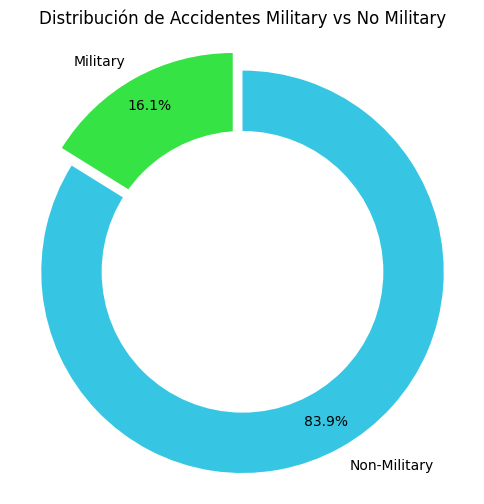

In [50]:
# Contar el número de vuelos "military" y "no military"
count_military = len(flight_df[flight_df['Military'] == 1])
count_non_military = len(flight_df[flight_df['Military'] == 0])  # El total de vuelos no militares

# Etiquetas para las categorías
labels = ['Military', 'Non-Military']

# Datos a representar en el gráfico de torta
sizes = [count_military, count_non_military]

# Colores para las partes del gráfico
colors = ['#36e345', '#36c6e3']

# Explode para destacar una porción
explode = (0.1, 0)

# Crear el gráfico de torta
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

# Añadir un círculo en el centro para que parezca una dona
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Título del gráfico
plt.title('Distribución de Accidentes Military vs No Military')

# Mostrar el gráfico
plt.axis('equal')  # Asegura que el gráfico sea circular
plt.show()


In [51]:
acc_non_military = flight_df[flight_df['Military'] == 0]

In [52]:
# Análisis de Pareto - 50%

# Contar la frecuencia de cada país
frequency = acc_non_military['Operator'].value_counts().reset_index()
frequency.columns = ['Operador', 'Frecuencia']

# Calcular la frecuencia relativa (porcentaje de frecuencia)
total = len(acc_non_military)
frequency['Frecuencia_Relativa'] = (frequency['Frecuencia'] / total) * 100

# Ordenar los países por frecuencia descendente
frequency = frequency.sort_values(by='Frecuencia', ascending=False)

# Calcular la frecuencia acumulada
frequency['Frecuencia_Acumulada'] = frequency['Frecuencia_Relativa'].cumsum()

In [53]:
ratio_50 = round((frequency[frequency['Frecuencia_Acumulada'] < 50].shape[0]/
frequency[frequency['Frecuencia_Acumulada'] < 101].shape[0])  *100 ,2)

print(f'el 50% de los accidentes corresponden al {ratio_50}% de los Operadores/Aerolíneas ')

el 50% de los accidentes corresponden al 9.78% de los Operadores/Aerolíneas 


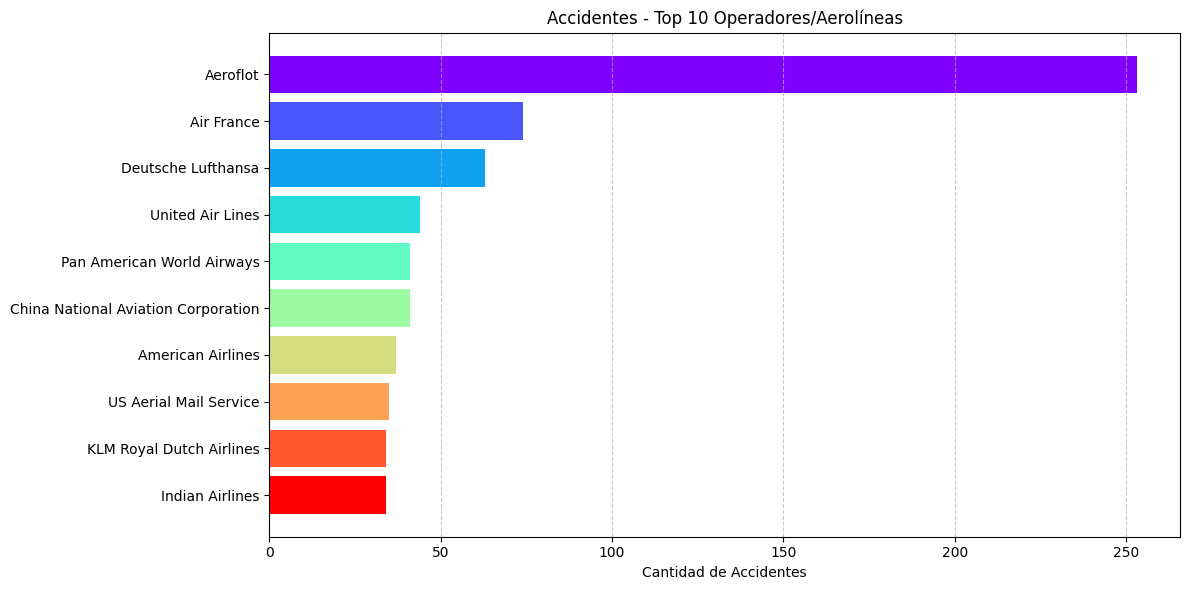

In [54]:
top_10_op = frequency.head(10)

# Crea una secuencia de valores entre 0 y 1
colores_secuencia = np.linspace(0, 1, len(top_10_op))

# Crea la paleta de colores tipo "rainbow" a partir de la secuencia
colores_rainbow = plt.cm.rainbow(colores_secuencia)

# Crea el gráfico de barras horizontales con cuadrícula
plt.figure(figsize=(12, 6))
plt.barh(top_10_op['Operador'], top_10_op['Frecuencia'], color=colores_rainbow)
plt.xlabel('Cantidad de Accidentes')
plt.title('Accidentes - Top 10 Operadores/Aerolíneas')
plt.gca().invert_yaxis()  # Invierte el eje y para que el operador con mayor frecuencia esté en la parte superior

# Agrega una cuadrícula al gráfico
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Cuadrícula en el eje x con estilo de línea discontinua y transparencia

plt.tight_layout()
plt.show()


La Aerolínea Aeroflot tiene la mayor cantidad de registros de accidentes fatales, siendo estos más de 3 veces la cantidad de la segunda aerolínea en la lista.

### 3.5 Columna 'AC Model', creación de la columna 'Brand'

Se crea la columna 'Brand' que reflejará el intento de identificar la marca de cada aeronáve.

In [55]:
flight_df['AC Model'] = flight_df['AC Model'].fillna('').astype(str)

In [56]:
AC_brands =[
    'Aichi', 'Airbus', 'Antonov', 'Armstrong Whitworth Aircraft', 'Avro',
    'Aérospatiale', 'Beechcraft', 'Bell Aircraft Corporation', 'Blackburn Aircraft', 'Boeing',
    'Breguet Aviation', 'Bristol Aeroplane Company', 'Cessna', 'Convair', 'Curtiss-Wright Corporation',
    'De Havilland', 'Dornier', 'English Electric', 'Fairchild Aircraft', 'Fokker', 'Grumman', 'Handley Page',
    'Handley Page', 'Harbin Aircraft Manufacturing Corporation', 'Hawker', 'Ilyushin', 'Junkers',
    'Kawasaki Heavy Industries', 'Lockheed Martin', 'Martin Marietta', 'McDonnell Douglas', 'Messerschmitt',
    'Mitsubishi Heavy Industries', 'Nakajima', 'Northrop Grumman', 'Piaggio Aerospace', 'Piper Aircraft', 'Saab',
    'Short Brothers', 'Sikorsky Aircraft Corporation', 'Sopwith Aviation Company', 'Sud Aviation', 'Supermarine',
    'Tupolev', 'Vickers', 'Vought', 'Wright Brothers', 'Yakovlev'
    ]

In [57]:
# Función para asignar valores a la columna 'brand'
def brand(aircraft_type):
    for brand in AC_brands:
        if any(word.lower() in aircraft_type.lower().split() for word in brand.split()):
            return brand
    try: return aircraft_type.split()[0]
    except: 'Unknown'

# Aplicamos la función a la columna 'AC Model' para crear la columna 'brand'
flight_df['Brand'] = flight_df['AC Model'].apply(brand)

In [58]:
flight_df.head(3)

,Date,Time,Loc Acc,Operator,Route,AC Model,Total Aboard,Passengers,Crew,Total Fatalities,Passengers Fatalities,Crew Fatalities,Summary,Location,Military,Brand
0,1908-09-17,17,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1.0,1.0,1.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly...",USA,1,Wright Brothers
1,1909-09-07,None,"Juvisy-sur-Orge, France",None,Air show,Wright Byplane,1.0,0.0,1.0,1.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...,France,0,Wright Brothers
2,1912-07-12,06,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.0,0.0,5.0,5.0,0.0,5.0,First U.S. dirigible Akron exploded just offsh...,USA,1,Dirigible


In [59]:
# Análisis de Pareto - 50%

brand = flight_df['Brand']

# Contar la frecuencia de cada aeronave
frequency = brand.value_counts().reset_index()
frequency.columns = ['Aeronave', 'Frecuencia']

# Calcular la frecuencia relativa (porcentaje de frecuencia)
total = len(acc_non_military)
frequency['Frecuencia_Relativa'] = (frequency['Frecuencia'] / total) * 100

# Ordenar los países por frecuencia descendente
frequency = frequency.sort_values(by='Frecuencia', ascending=False)

# Calcular la frecuencia acumulada
frequency['Frecuencia_Acumulada'] = frequency['Frecuencia_Relativa'].cumsum()

In [60]:
# Top 10 aeronaves con más accidentes
frequency.head(10)

,Aeronave,Frecuencia,Frecuencia_Relativa,Frecuencia_Acumulada
0,McDonnell Douglas,1116,26.596759,26.596759
1,Boeing,411,9.795043,36.391802
2,Lockheed Martin,350,8.341277,44.733079
3,De Havilland,291,6.935176,51.668255
4,Antonov,287,6.839847,58.508103
5,Fokker,139,3.312679,61.820782
6,Ilyushin,139,3.312679,65.133460
7,Curtiss,118,2.812202,67.945663
8,Tupolev,104,2.478551,70.424214
9,Vickers,92,2.192564,72.616778


Las aeronáves 'McDonnell Douglas'	 tienen la mayor cantidad de registros de accidentes fatales, siendo estos más de 2 veces la cantidad de la segunda aeronave en la lista.

### 3.6 Columna AC Classification (nueva columna)

Esta columna hace referencia a la clasificación más básica de las aeronaves, aqui solo se encuentran las categorias:
Zeppelin (Globo dirigible y similares) , Airplane (Aviones comerciales, militares y charters) y Helicopter (Helicopteros)

In [61]:
# Crea una nueva columna "AC Classification" con valor inicial 'Airplane'
flight_df['AC Classification'] = 'Airplane'

# Verifica si la columna "Operator" contiene la palabra 'Helicopter' y asigna 'Helicopter' en "AC Classification"
flight_df.loc[flight_df['Operator'].str.contains(
                                                'Helicopter', case=False, na=False
                                                ),
                                                'AC Classification'] = 'Helicopter'

# Verifica si la columna "AC Model" contiene las palabras 'Zeppelin', 'Dirigible' o 'airship' y asigna 'Zeppelin' en "AC Classification"
flight_df.loc[flight_df['AC Model'].str.contains(
                                                'Zeppelin|Dirigible|airship', case=False, na=False
                                                ),
                                                'AC Classification'] = 'Zeppelin'

In [62]:
flight_df[['Operator', 'AC Model' , 'AC Classification']].head(5)

,Operator,AC Model,AC Classification
0,Military - U.S. Army,Wright Flyer III,Airplane
1,None,Wright Byplane,Airplane
2,Military - U.S. Navy,Dirigible,Zeppelin
3,Private,Curtiss seaplane,Airplane
4,Military - German Navy,Zeppelin L-1 (airship),Zeppelin


### 3.7 Columna 'Summary' y creación de la columna 'Climatic Factor'

In [63]:
# Nube de Palabras de la columna 'Summary'
resumen = flight_df['Summary'].fillna('')

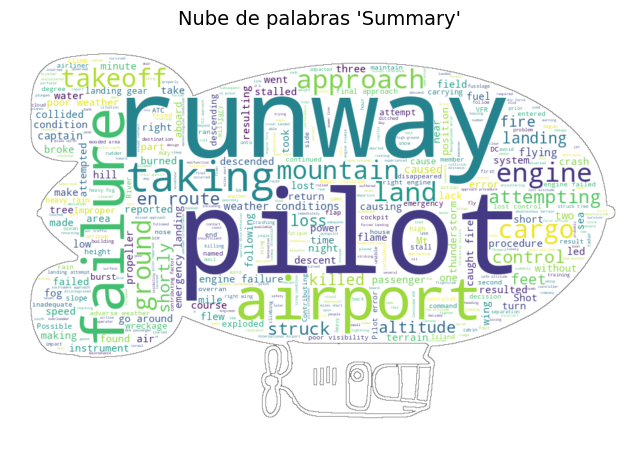

In [64]:
text = str(resumen.tolist())

zeppelin_mask = np.array(Image.open('zeppelin.png'))

stopwords = set(STOPWORDS)
stopwords.add('aircraft')
stopwords.add('airplane')
stopwords.add('helicopter')
stopwords.add('zeppelin')
stopwords.add('plane')
stopwords.add('due')
stopwords.add('hit')
stopwords.add('left')
stopwords.add('ft')
stopwords.add('crashed')
stopwords.add('flight')
stopwords.add('accident')
stopwords.add('crew')

wc = WordCloud(background_color="white", max_words=2000, mask=zeppelin_mask,
               stopwords=stopwords, contour_width=1, contour_color='grey')
wc.generate(text)

plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras 'Summary'", loc='Center', fontsize=14)
plt.show()

Se crea la columna 'Climatic Factor' que reflejará la incidencia de factores climatológicos en los accidentes.
esta incidencia se expresa en números binarios donde:

 0. No existe un indicio claro de factores climatologicos en los accidentes.
 1. Si hay un indicio de factores climatológicos en los accidentes.

In [65]:
# Lista de palabras (en inglés) que denotan factores negativos durante la actividad aérea y
# por ende, si aparecen en los textos de la columna 'Summary' se dará por entendido que
# en el accidente existió una influencia climatológica en el accidente.

negative_climatic_factors = [
    "Storm", "Heavy Rain", "Thunderstorm", "Turbulence", "Hailstorm", "Blizzard",
    "Hurricane", "Cyclone", "Tornado", "Fog", "Freezing Rain", "Ice Storm",
    "Low Visibility", "Strong Winds", "Lightning", "Severe Weather", "Icing",
    "Microburst", "Wind Shear", "Low Pressure System", "Dense Fog", "Snowstorm",
    "Heavy Snowfall", "Icy Conditions", "Severe Turbulence", "Hazardous Weather",
    "Adverse Conditions", "Weather Delays", "Natural Disasters", "Weather-Related Issues"
]

In [66]:
# Crea la columna "Climatic Factor" y asigna 1 si Summary contiene alguna palabra clave, de lo contrario, asigna 0
flight_df['Climatic Factor'] = flight_df['Summary'].str.contains('|'.join(negative_climatic_factors), case=False, na=False).astype(int)

In [67]:
flight_df.head(4)

,Date,Time,Loc Acc,Operator,Route,AC Model,Total Aboard,Passengers,Crew,Total Fatalities,Passengers Fatalities,Crew Fatalities,Summary,Location,Military,Brand,AC Classification,Climatic Factor
0,1908-09-17,17,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1.0,1.0,1.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly...",USA,1,Wright Brothers,Airplane,0
1,1909-09-07,None,"Juvisy-sur-Orge, France",None,Air show,Wright Byplane,1.0,0.0,1.0,1.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...,France,0,Wright Brothers,Airplane,0
2,1912-07-12,06,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.0,0.0,5.0,5.0,0.0,5.0,First U.S. dirigible Akron exploded just offsh...,USA,1,Dirigible,Zeppelin,0
3,1913-08-06,None,"Victoria, British Columbia, Canada",Private,None,Curtiss seaplane,1.0,0.0,1.0,1.0,0.0,1.0,The first fatal airplane accident in Canada oc...,Canada,0,Curtiss,Airplane,1


### 3.8 Análisis de Globos Dirigibles y Helicópteros

Los aviones son más estables que los helicópteros debido a su diseño aerodinámico y a la presencia de alas. Esto hace que sean más fáciles de controlar en el aire y menos susceptibles a las ráfagas de viento y las turbulencias.
En este análisis se pretende evidenciar la influencia del clima en los accidentes de helicópteros y dirigibles.
Si el clima es un factor relevante, existiría una asociación entre este factor y las aeronaves.

In [68]:
# Cantidad de accidentes segmentado por la influencia (o no) de factores climatológicos en los helicópteros y dirigibles

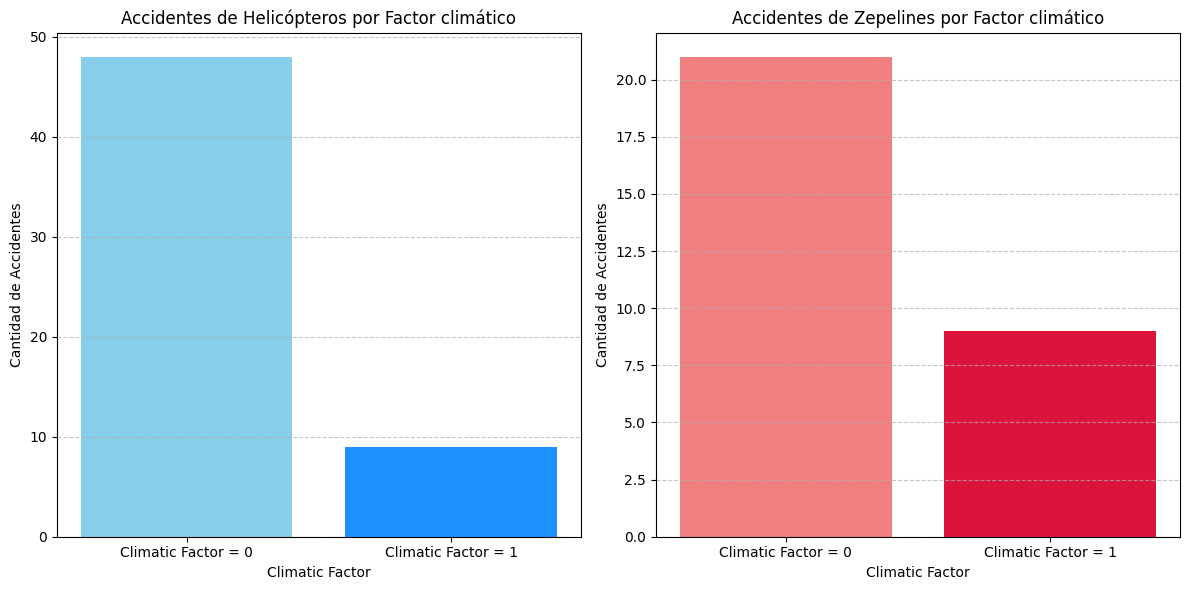

In [69]:
# Filtra los registros correspondientes a helicópteros y dirigibles por separado
helicopters_df = flight_df[flight_df['AC Classification'] == 'Helicopter']
zeppelins_df = flight_df[flight_df['AC Classification'] == 'Zeppelin']

# Crea subplots para dos pares de barras
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de barras para helicópteros
colors_helicopters = ['skyblue', 'dodgerblue']
axs[0].bar([0, 1], helicopters_df['Climatic Factor'].value_counts().sort_index(), color=colors_helicopters, tick_label=['Climatic Factor = 0', 'Climatic Factor = 1'])
axs[0].set_xlabel('Climatic Factor')
axs[0].set_ylabel('Cantidad de Accidentes')
axs[0].set_title('Accidentes de Helicópteros por Factor climático')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico de barras para globos dirigibles
colors_zeppelins = ['lightcoral', 'crimson']
axs[1].bar([0, 1], zeppelins_df['Climatic Factor'].value_counts().sort_index(), color=colors_zeppelins, tick_label=['Climatic Factor = 0', 'Climatic Factor = 1'])
axs[1].set_xlabel('Climatic Factor')
axs[1].set_ylabel('Cantidad de Accidentes')
axs[1].set_title('Accidentes de Zepelines por Factor climático')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Ajusta el espaciado entre subplots
plt.tight_layout()
plt.show()

Se puede apreciar que los accidentes "influenciados" por factores climatológicos son escasos para dichas aeronaves.

In [70]:
# Test Chi-cuadrada para determinar estadísticamente si existe alguna
# asociación entre las variables categóricas.
# En este caso, las variables son el factor climático 'Climatic Factor' y las aeronaves (helicópteros y dirigbles)

In [71]:
from scipy.stats import chi2_contingency

x = flight_df['AC Classification'].isin(['Helicopter' , 'Zeppelin'])

# Crear una tabla de contingencia
contingency_table = pd.crosstab(x, flight_df['Climatic Factor'])

# Realizar la prueba de chi-cuadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

# Imprimir los resultados
print("Chi-cuadrado:", chi2)
print("Valor p:", p)

# Interpretar los resultados
alpha = 0.05  # Nivel de significancia
if p < alpha:
    print("Hay una relación significativa entre 'AC Classification' y 'Climatic Factor'.")
else:
    print("No hay evidencia de una relación significativa entre las variables.")

Chi-cuadrado: 0.035479865259625154
Valor p: 0.8505936721361301
No hay evidencia de una relación significativa entre las variables.


Basados en la información anterior, se puede concluir que el factor climatológico "Climatic Factor" , no tiene una relación significativa con los accidentes de las aeronaves analizadas.

### 3.9 Análisis de Supervivencia

Este análisis esta orientado a evaluar la tasa de superivencia en los distintos accidentes y de esta manera deducir someramente si la seguridad de las aeronaves y pericia de los pilotos, mejorada a través de los años, convergen en una mayor probabilidad a sobrevivir a este tipo de accidentes.

In [72]:
# Creación de la columna '% Survivors'
flight_df['% Survivors'] = 100 - (flight_df['Total Fatalities']*100/flight_df['Total Aboard']).astype(float).round(0)

In [73]:
flight_df.head(4)

,Date,Time,Loc Acc,Operator,Route,AC Model,Total Aboard,Passengers,Crew,Total Fatalities,Passengers Fatalities,Crew Fatalities,Summary,Location,Military,Brand,AC Classification,Climatic Factor,% Survivors
0,1908-09-17,17,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1.0,1.0,1.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly...",USA,1,Wright Brothers,Airplane,0,50.0
1,1909-09-07,None,"Juvisy-sur-Orge, France",None,Air show,Wright Byplane,1.0,0.0,1.0,1.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...,France,0,Wright Brothers,Airplane,0,0.0
2,1912-07-12,06,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.0,0.0,5.0,5.0,0.0,5.0,First U.S. dirigible Akron exploded just offsh...,USA,1,Dirigible,Zeppelin,0,0.0
3,1913-08-06,None,"Victoria, British Columbia, Canada",Private,None,Curtiss seaplane,1.0,0.0,1.0,1.0,0.0,1.0,The first fatal airplane accident in Canada oc...,Canada,0,Curtiss,Airplane,1,0.0


### 3.9.1 Columna 'Year'

Se crea la columna referente a los años de cada registro con la finalidad de agrupar los diferentes accidentes por el año.

In [74]:
# Agrega una columna 'Year' para extraer el año de la fecha
flight_df['Year'] = flight_df['Date'].dt.year

### 3.9.2 Aviones Comerciales

Analizar los aviones de indole comercial es de sumo interés debido a la cantidad de personas que estos transportan, sumado a  los riesgos que esta actividad representa.
La cantidad de pérdidas humanas y las implicaciones económicas asociadas a un accidente de estas aeronaves pueden cobrar grandes dimensiones y, el esfuerzo por prevenirlas y mitigarlas es continuo en todo el mundo.
Serán considerados los aviones comerciales con más de 200 persona a bordo.

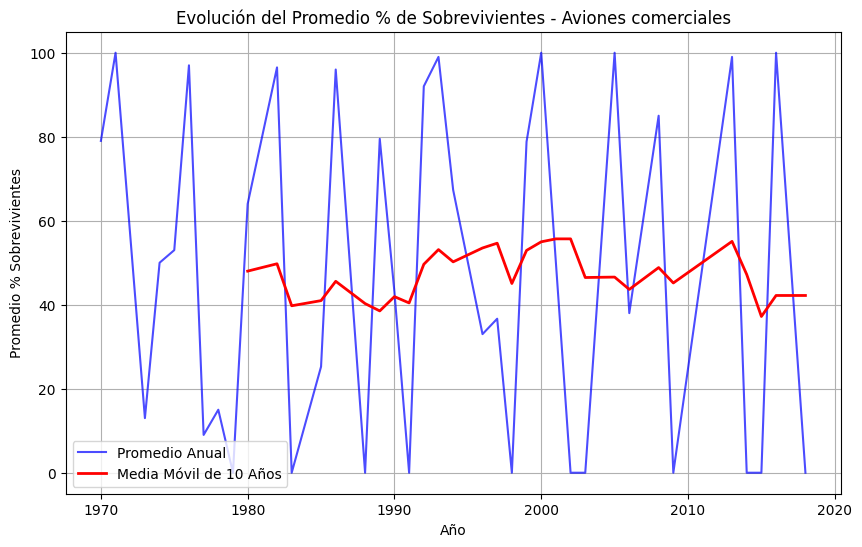

In [75]:
# Gráfica de la evolución del "% de sobrevivientes" en los aviones

# Filtra el DataFrame para obtener solo los aviones
airplane = flight_df['AC Classification'] == 'Airplane'
comercial = flight_df['Total Aboard'] > 200
airplanes_df = flight_df[airplane & comercial]

# Agrupa por año y calcula el promedio de '% Survivors'
airplanes_grouped = airplanes_df.groupby('Year')['% Survivors'].mean()

# Calcula la media móvil de 10 años
rolling_mean = airplanes_grouped.rolling(window=10).mean()

# Crea una gráfica de líneas para los datos originales
plt.figure(figsize=(10, 6))
plt.plot(airplanes_grouped.index, airplanes_grouped.values, label='Promedio Anual',  color='blue', alpha=0.7)
plt.plot(airplanes_grouped.index, rolling_mean.values, label='Media Móvil de 10 Años', color='red', linewidth=2)
plt.xlabel('Año')
plt.ylabel('Promedio % Sobrevivientes')
plt.title('Evolución del Promedio % de Sobrevivientes - Aviones comerciales')
plt.legend()
plt.grid(True)

# Muestra la gráfica de líneas
plt.show()


In [76]:
# Cantidad de registros
acc = airplanes_df.groupby('Year')['% Survivors'].mean().value_counts().sum()
print(f'Cantidad de años (no consecutivos) de accidentes: {acc}')

# Cantidad de registros que muestran un porcentaje de supervivencia mayor al 50%
fifty = (airplanes_df.groupby('Year')['% Survivors'].mean() > 50).sum()
print(f'Cantidad de años con tasa de supervivencia > 50% anual: {fifty}')

Cantidad de años (no consecutivos) de accidentes: 38
Cantidad de años con tasa de supervivencia > 50% anual: 17


En 17 de 38 años contabilizados, la tasa de supervivencia supera el 50%.

Los registros que superan la media móvil son, en principio, buenos indicativos;
reflejan que, el promedio anual del porcentaje de personas que han sobrevivido es mayor que la media de los 10 años anteriores.

### 3.9.3 Helicópteros

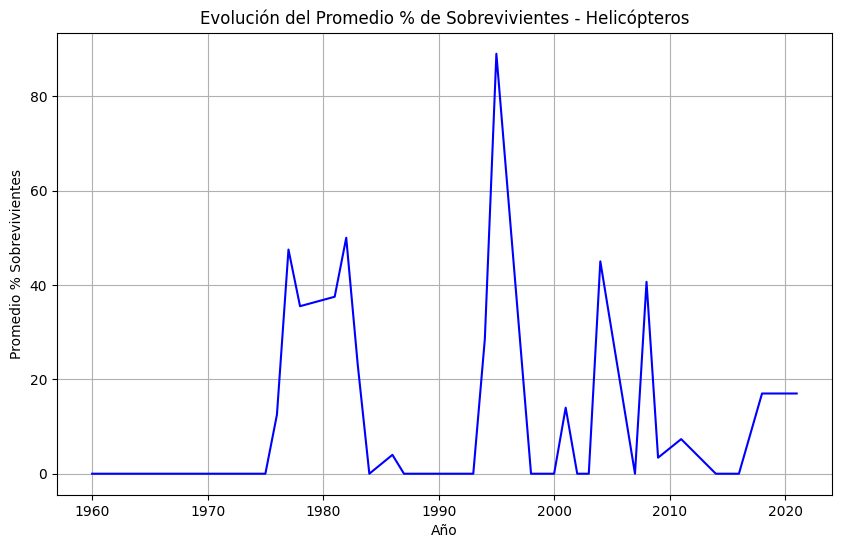

In [77]:
# Filtra el DataFrame para obtener solo los helicópteros
helicopters_df = flight_df[flight_df['AC Classification'] == 'Helicopter']

# Agrupa por año y calcula el promedio de '% Survivors'
helicopters_grouped = helicopters_df.groupby('Year')['% Survivors'].mean()

# Crea una gráfica de líneas
plt.figure(figsize=(10, 6))
plt.plot(helicopters_grouped.index, helicopters_grouped.values, color='blue')
plt.xlabel('Año')
plt.ylabel('Promedio % Sobrevivientes')
plt.title('Evolución del Promedio % de Sobrevivientes - Helicópteros')
plt.grid(True)

# Muestra la gráfica de líneas
plt.show()


In [78]:
#Cantidad de registros que muestran un porcentaje de supervivencia mayor al 50%
(helicopters_df.groupby('Year')['% Survivors'].mean() > 50).sum()

1

En solo uno de los accidentes la supervivencia fue del 50% (sobrevivieron más de la mitad de las persona a bordo).

### 3.9.4 Globos Dirigibles

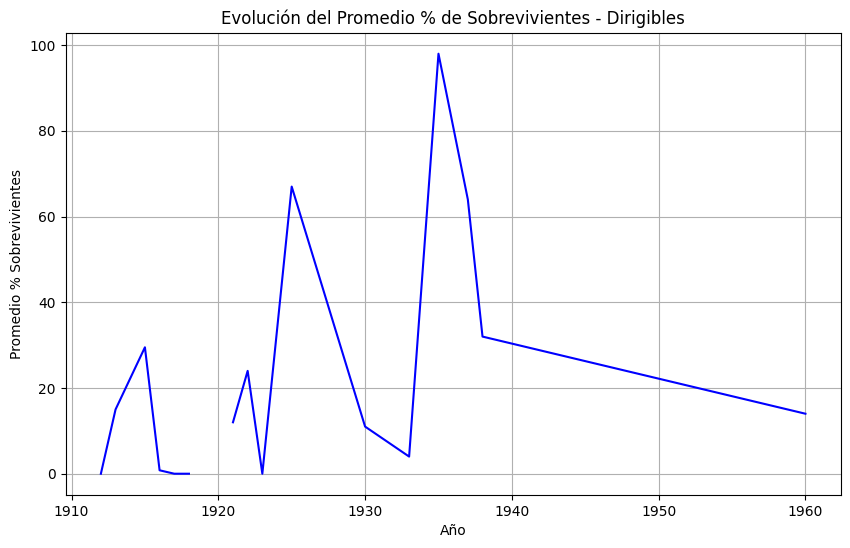

In [79]:
# Filtra el DataFrame para obtener solo los golbos dirigibles
zeppelins_df = flight_df[flight_df['AC Classification'] == 'Zeppelin']

# Agrupa por año y calcula el promedio de '% Survivors'
zeppelins_grouped = zeppelins_df.groupby('Year')['% Survivors'].mean()

# Crea una gráfica de líneas
plt.figure(figsize=(10, 6))
plt.plot(zeppelins_grouped.index, zeppelins_grouped.values , color='blue')
plt.xlabel('Año')
plt.ylabel('Promedio % Sobrevivientes')
plt.title('Evolución del Promedio % de Sobrevivientes - Dirigibles')
plt.grid(True)

# Muestra la gráfica de líneas
plt.show()

In [80]:
#Cantidad de registros que muestran un porcentaje de supervivencia mayor al 50%
(zeppelins_df.groupby('Year')['% Survivors'].mean() > 50).sum()

3

En solo 3 de los accidentes la supervivencia fue del 50% (sobrevivieron más de la mitad de las persona a bordo).

### 3.10 Evolución de la cantidad de accidentes anuales

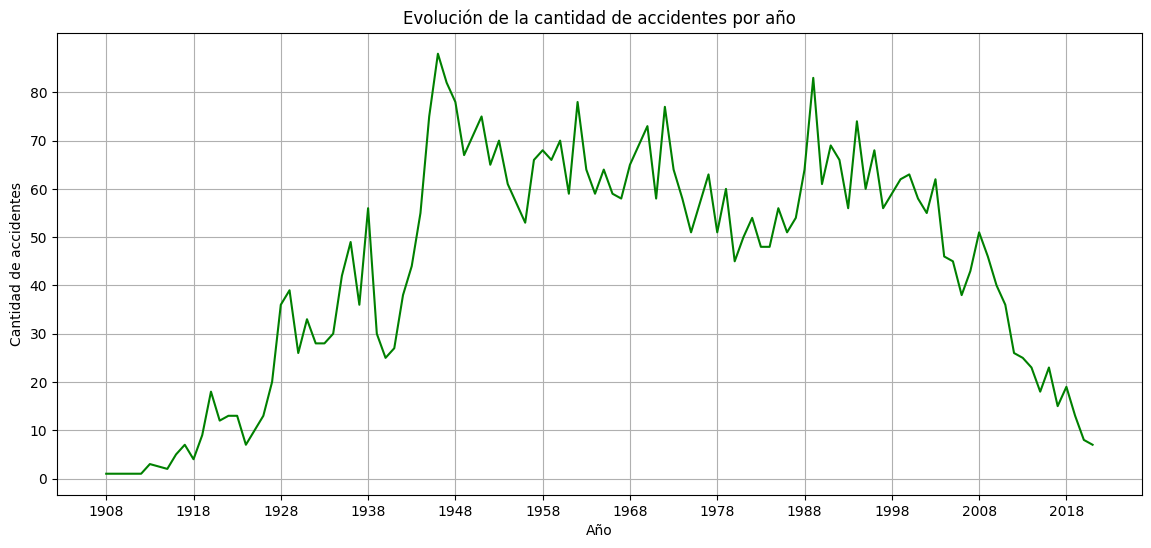

In [81]:
# Agrupamos por año y contamos la cantidad de accidentes
accidents_by_year = flight_df.groupby('Year').size().reset_index(name='Cantidad de accidentes')

# Creamos el gráfico de líneas
plt.figure(figsize=(14, 6))
plt.plot(accidents_by_year['Year'], accidents_by_year['Cantidad de accidentes'], color='green', label='Cantidad de accidentes')

# Establecemos separación del eje x cada 5 años
plt.xticks(range(min(accidents_by_year['Year']), max(accidents_by_year['Year'])+1, 10))

# Establecemos separación del eje y cada 10 unidades
plt.yticks(range(0, max(accidents_by_year['Cantidad de accidentes'])+1, 10))

# Mostramos gridlines
plt.grid(True)

# Establecemos etiquetas de los ejes
plt.xlabel('Año')
plt.ylabel('Cantidad de accidentes')

# Establecemos título del gráfico
plt.title('Evolución de la cantidad de accidentes por año')

# Mostramos el gráfico
plt.show()


Según la gráfica, la cantidad de accidentes tiene una tendencia descendente en los últimos 20 años.

### CSV

In [82]:
# Reemplaza todos los '' o 'None' por NaN en todo el DataFrame
flight_df.replace('None', np.nan, inplace=True)
flight_df.replace('', np.nan, inplace=True)

In [83]:
# Se Cambia la fecha al tipo yyyy-mm-dd
flight_df['Date'] = pd.to_datetime(flight_df['Date'], format='%Y-%m-%d')

In [84]:
# Se Cambia a tipo flotantes las columnas correspondientes
col_to_int = [
    'Time' , 'Total Aboard' , 'Passengers' , 'Crew' ,
    'Total Fatalities' , 'Passengers Fatalities' , 'Crew Fatalities',
    'Military' , 'Climatic Factor' , '% Survivors'
    ]

flight_df[col_to_int] = flight_df[col_to_int].astype(float)

In [85]:
# Se Cambia a tipo string las columnas correspondientes
col_to_int = [
    'Loc Acc' , 'Operator' , 'Route' , 'AC Model' , 'Summary' , 'Brand' , 'AC Classification'
    ]

flight_df[col_to_int] = flight_df[col_to_int].astype(str)

In [86]:
# Se guarda el dataframe "flight_df" a CSV
flight_df.to_csv('AC_accidents_OUTPUTS.csv', index=False, sep = ';', quoting= csv.QUOTE_ALL)